# Pure Random Walk Simulation

Q: How well can a cell find high ligand concentration using just random walk?

The file includes:
 - Model specification
 - Visualizing the trajectories for 3 cells in response to gradients with different background tumbling frequencies
 - Measuring collective performance of cells

## Part1: Model specification

#### Assumptions
1. Run. The duration of run follows an exponential distrubtion with mean equals to the background run duration `time_exp`.
2. Tumble. The duration of cell tumble follows an exponential distribution with mean 0.1s. When it tumbles, we assume it only changes the orientation for the next run but doesn't move in space. The degree of reorientation follows a normal distribution with mean of 68° and standard deviation of 36°.
3. Gradient. We model an exponential gradient centered at [1500, 1500] with a concentration of 10^8. All cells start at [0, 0], which has a concentration of 10^2. The receptors saturate at a concentration of 10^8. 
5. Performance. The closer to the center of the gradient the better.

#### Dependencies
Please makes sure have dependencies installed:
 - [Numpy](https://numpy.org/install/)
 - [Matplotlib](https://matplotlib.org/users/installing.html)
 - [Colorspace](https://python-colorspace.readthedocs.io/en/latest/installation.html) (simply [install with pip](https://pypi.org/project/colorspace/) works too)

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib import colors
from matplotlib import patches
import colorspace

#### Specifying parameters

In [36]:
SEED = 128  #Any random seed
np.random.seed(SEED)

#Constants for E.coli tumbling
tumble_angle_mu, tumble_angle_std = 2 * math.pi * 68 / 360, 2 * math.pi * 36 / 360 #Degree of reorientation when tumble
tumble_time_mu = 0.1

#E.coli movement constants
speed = 20         #um/s, speed of E.coli movement

#Model constants
start = [0, 0]  #All cells start at [0, 0]
ligand_center = [1500, 1500] #Position of highest concentration
center_exponent, start_exponent = 8, 2
origin_to_center = 0 #Distance from start to center, intialized here, will be actually calculated later
saturation_conc = 10 ** 8 #From BNG model

#### Helper function: calculate Euclidean distance

In [37]:
# Calculates Euclidean distance between point a and b
def euclidean_distance(a, b):
    return math.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)

#### Function to calculate concentration at a current location
We model an exponential gradient centered at [1500, 1500] with a concentration of 10^8. All cells start at [0, 0], which has a concentration of 10^2.

In [38]:
# Exponential gradient, the exponent follows a linear relationship with distance to center
def calc_concentration(pos):
    dist = euclidean_distance(pos, ligand_center)
    exponent = (1 - dist / origin_to_center) * (center_exponent - start_exponent) + start_exponent
    
    return 10 ** exponent

#### Function to calculate tumble duration and reorientation

The duration of cell tumble follows an exponential distribution with mean 0.1s. When it tumbles, we assume it only changes the orientation for the next run but doesn't move in space. 

The degree of reorientation follows a uniform distribution with mean 68° and std 36°.

Also return the horizontal and vertical movement of the cell for the following run.

In [39]:
# Horizontal and Vertical movement of tumbling
def tumble_move(curr_dir):
    #Sample the new direction
    new_dir = np.random.normal(loc = tumble_angle_mu, scale = tumble_angle_std)
    new_dir *= np.random.choice([-1, 1])
    new_dir += curr_dir
    
    if new_dir > 2 * math.pi:
        new_dir -= 2 * math.pi #Keep within [0, 2pi]
        
    move_h = math.cos(new_dir) #Horizontal displacement for next run
    move_v = math.sin(new_dir) #Vertical displacement for next run
    
    tumble_time = np.random.exponential(tumble_time_mu) #Length of the tumbling
    
    return new_dir, move_h, move_v, tumble_time

#### Function for simulation

It handles simulation through time for all cells.

For each cell, simulate through time as the following:

while `t` < duration:
- Sample the current run duration `curr_run_time`
- Run for `curr_run_time` second along current direction
- Sample the duration of tumble `tumble_time` and the resulted direction
- increment t by `curr_run_time` and `tumble_time`

In [40]:
def simulate_std_random(num_cells, duration, time_exp):

    path = np.zeros((num_cells, duration + 1, 2))
    terminals = []

    for rep in range(num_cells):
        # Initialize simulation
        t = 0
        curr_position = np.array(start)
        curr_direction, move_h, move_v, tumble_time = tumble_move(0) #Initialize direction randomly
        past_sec = 0

        while t < duration:

            curr_run_time = np.random.exponential(time_exp) #get wait time before tumble

            curr_position = curr_position + np.array([move_h, move_v]) * speed * curr_run_time
            curr_direction, move_h, move_v, tumble_time = tumble_move(curr_direction)
            t += (curr_run_time + tumble_time)

            #record position approximate for integer number of second
            curr_sec = int(t)
            for sec in range(past_sec, min(curr_sec, duration) + 1):
                path[rep, sec] = curr_position.copy()
                past_sec= curr_sec

        terminals.append((path[rep, -1]))
    
    return terminals, path

## Part2: Visualizing trajectories

Run simulations for `time_exp` = 1.0, 3 cells, for 800 seconds.

In [41]:
#Run simulation for 3 cells with different background tumbling frequencies, Plot path

duration = 800   #seconds, duration of the simulation
num_cells = 3
origin_to_center = euclidean_distance(start, ligand_center) #Update the global constant
time_exp = 1.0


terminals, path = simulate_std_random(num_cells, duration, time_exp)
print(terminals)

[array([-463.97160294, -168.00566611]), array([-619.06601004, -606.62483229]), array([ 323.46446609, -287.27920808])]


#### Plotting the trajectories.

It will take some time to run.

- The background color white->red indicates ligand concentration
- Black dot indicates starting position of all cells ([0, 0]).
- Red dot indicates terminal position of all cells.
- The dashed line with colors dark->ligt green/cyan/purple indicates trajectories of the three cells. Darker dots indicate earlier time points.
- If the center has a higher concentration than 10^8 (saturation), the dark dashed circle indicates inside which concentration>10^8.

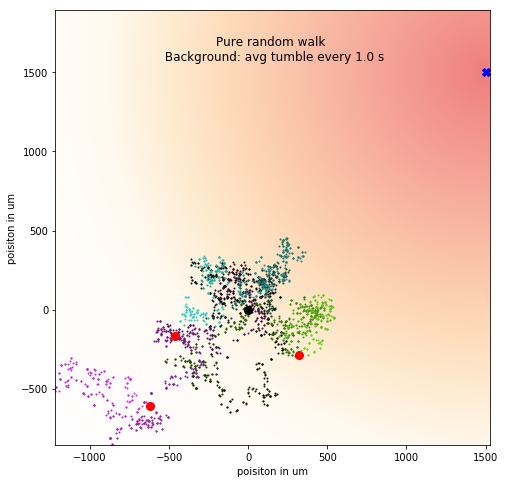

In [43]:
#Below are all for plotting purposes
radius_saturation = (1 - ((math.log10(saturation_conc) - start_exponent) / (center_exponent - start_exponent))) * origin_to_center

fig, ax = plt.subplots(1, 1, figsize = (8, 8))

#First set color map
mycolor = [[256, 256, 256], [256, 255, 254], [256, 253, 250], [256, 250, 240], [255, 236, 209], [255, 218, 185], [251, 196, 171], [248, 173, 157], [244, 151, 142], [240, 128, 128]] #from coolors：）
for i in mycolor:
    for j in range(len(i)):
        i[j] *= (1/256)
cmap_color = colors.LinearSegmentedColormap.from_list('my_list', mycolor)

xlen = max(max(path[:,:,0].flatten()), 1530) - min(path[:,:,0].flatten())
ylen = max(max(path[:,:,1].flatten()), 1530) - min(path[:,:,1].flatten())
sqrlen = int(round(max(xlen, ylen), 0))
xlim_l, xlim_h = min(path[:,:,0].flatten()), min(path[:,:,0].flatten()) + sqrlen
ylim_l, ylim_h = min(path[:,:,1].flatten()), min(path[:,:,1].flatten()) + sqrlen


#Simulate the gradient distribution, plot as a heatmap
conc_matrix = np.zeros((sqrlen, sqrlen))
for i in range(sqrlen):
    for j in range(sqrlen):
        conc_matrix[i][j] = calc_concentration([i + xlim_l, j + ylim_l])
conc_matrix = np.log(conc_matrix)
ax.imshow(conc_matrix.T, cmap=cmap_color, interpolation='nearest', extent = [xlim_l, xlim_h, ylim_l, ylim_h], origin = 'lower')

#Plot simulation results
time_frac = 1.0 / duration
#Time progress: dark -> colorful
for t in range(duration):
    ax.plot(path[0,t,0], path[0,t,1], 'o', markersize = 1, color = (0.2 * time_frac * t, 0.85 * time_frac * t, 0.8 * time_frac * t))
    ax.plot(path[1,t,0], path[1,t,1], 'o', markersize = 1, color = (0.85 * time_frac * t, 0.2 * time_frac * t, 0.9 * time_frac * t))
    ax.plot(path[2,t,0], path[2,t,1], 'o', markersize = 1, color = (0.4 * time_frac * t, 0.85 * time_frac * t, 0.1 * time_frac * t))
ax.plot(start[0], start[1], 'ko', markersize = 8)
for i in range(num_cells):
    ax.plot(terminals[i][0], terminals[i][1], 'ro', markersize = 8)
#ax.plot(path[:,0], path[:,1], '-', color = 'grey')

#Indicate the saturation areas
circle1 = plt.Circle((ligand_center[0], ligand_center[0]), radius_saturation, fill = False, ec = "black", ls = '--')
ax.plot(1500, 1500, 'bX', markersize = 8)
ax.set_title("Pure random walk \n Background: avg tumble every {} s".format(time_exp), x = 0.5, y = 0.87)
ax.add_artist(circle1)
ax.set_xlim(xlim_l, xlim_h)
ax.set_ylim(ylim_l, ylim_h)
ax.set_xlabel("poisiton in um")
ax.set_ylabel("poisiton in um")

plt.show()

## Part3: Measuring collective performances

Run simulations for 500 cells, for 1500 seconds. Mean and std for Euclidean distance to the center are calculated at each time point.

It will take some time to run.

In [23]:
#Run simulation for 500 cells, plot average distance to highest concentration point
duration = 1500   #seconds, duration of the simulation
num_cells = 500
time_exp = 1.0
origin_to_center = euclidean_distance(start, ligand_center) #Update the global constant
radius_saturation = (1 - ((math.log10(saturation_conc) - start_exponent) / (center_exponent - start_exponent))) * origin_to_center

all_distance = np.zeros((num_cells, duration)) #Initialize to store results

terminals, paths = simulate_std_random(num_cells, duration, time_exp) #run simulation

for c in range(num_cells):
    for t in range(duration):
        pos = paths[c, t]
        dist = euclidean_distance(ligand_center, pos)
        all_distance[c, t] = dist

all_dist_avg = np.mean(all_distance, axis = 0)
all_dist_std = np.std(all_distance, axis = 0)

#### Plotting distances.

- Each colored line indicates a `time_exp`, plotting average distances for the 500 cells
- The shaded area is standard deviation
- Grey dashed line indicates distance below where concentration reaches 10^8.

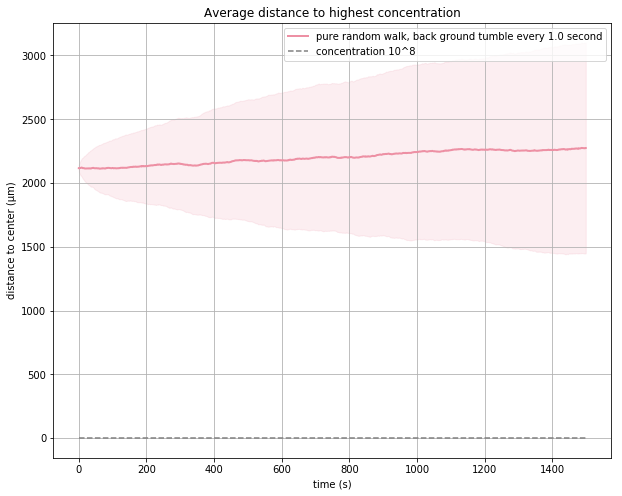

In [30]:
#Below are all for plotting purposes
#Define the colors to use
colors = colorspace.qualitative_hcl(h=[0, 300.], c = 60, l = 70, pallete = "dynamic")(1)

xs = np.arange(0, duration)

fig, ax = plt.subplots(1, figsize = (10, 8))

mu, sig = all_dist_avg, all_dist_std
ax.plot(xs, mu, lw=2, label="pure random walk, back ground tumble every {} second".format(time_exp), color=colors[0])
ax.fill_between(xs, mu + sig, mu - sig, color = colors, alpha=0.15)

ax.set_title("Average distance to highest concentration")
ax.set_xlabel('time (s)')
ax.set_ylabel('distance to center (µm)')
ax.hlines(radius_saturation, 0, duration, colors='gray', linestyles='dashed', label='concentration 10^8')
ax.legend(loc='upper right')

ax.grid()